In [103]:
from warnings import filterwarnings
filterwarnings('ignore')

# CXR Modality-specific pretraining

data used: Pediatric pneumonia CXR and Indiana CXR


During this training step, the combined CXR collection, including RSNA CXR, pediatric
pneumonia CXR, and Indiana CXR datasets, is split at the patient-level into 80%
for training and 20% for testing. With a fixed seed value, we allocated 10% of the training
data toward model validation.

In [104]:
import glob
filename = glob.glob(r'../../dataset/CXRMSP/train/ABNORMAL/*.*')
print(len(filename))
filename = glob.glob(r'../../dataset/CXRMSP/train/NORMAL/*.*')
print(len(filename))



12646
11743


In [105]:
import cv2
im = cv2.imread(filename[0])
im.shape

(2048, 2472, 3)

In [106]:
import datetime
import time

In [107]:
import tensorflow as tf
from tensorflow.keras.preprocessing  import image_dataset_from_directory
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate,concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import layers

In [108]:
train_dir = '../../dataset/CXRMSP/train/'
val_dir = '../../dataset/CXRMSP/val/'
# test_dir = '../dataset/CXRMSP/test/'
BATCH_SIZE = 16
IMG_SIZE = (256, 256)


In [109]:
train_dataset = image_dataset_from_directory(
    train_dir, 
    shuffle=True,
    validation_split=0.2,
    seed=123,
    label_mode='categorical',
    subset='training',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=IMG_SIZE)
val_dataset = image_dataset_from_directory(
    train_dir, 
    shuffle=True,
    validation_split=0.1,
    label_mode='categorical',
    seed=123,
    subset='validation',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(
    train_dir, 
    shuffle=True,
    validation_split=0.1,
    label_mode='categorical',
    seed=123,
    subset='validation',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=IMG_SIZE)

Found 24389 files belonging to 2 classes.
Using 19512 files for training.
Found 24389 files belonging to 2 classes.
Using 2438 files for validation.
Found 24389 files belonging to 2 classes.
Using 2438 files for validation.


In [110]:
# class_names = train_dataset.class_names
# print(class_names)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     print(labels)
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [111]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 1220
Number of validation batches: 153
Number of test batches: 153


In [112]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [113]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = Dropout(0.25)(x)
    x = Conv2D(128,3,name='final_conv',padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(2,activation='softmax')(x)
    return tf.keras.Model(inputs,output)


In [114]:
model = build_model(input_shape=(256,256,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.summary()   

Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-7 ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../../output/checkpoints/mobilenetv2/512_128weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        save_best_only=True,save_weights_only=True,verbose=1)
           ]

2022-06-10 15:17:42.999397: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-10 15:17:42.999409: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-10 15:17:42.999503: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [16]:
history = model.fit(train_dataset,
                    initial_epoch=0,
                    epochs=35,
                    validation_data=val_dataset,
                   callbacks=callback)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-10 15:17:52.789724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-10 15:17:52.798576: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-10 15:17:52.798862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   2/1220 [..............................] - ETA: 4:26 - loss: 7.8187 - accuracy: 0.4375 

2022-06-10 15:17:54.168937: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-10 15:17:54.168948: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-10 15:17:54.349661: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-10 15:17:54.355385: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-10 15:17:54.359232: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220610-151742/train/plugins/profile/2022_06_10_15_17_54
2022-06-10 15:17:54.361344: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220610-151742/train/plugins/profile/2022_06_10_15_17_54/users-MacBook-Pro.local.trace.json.gz
2022-06-10 15:17:54.364080: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220610-151742/tr

1220/1220 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8280WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x168ed85e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-10 15:21:19.678019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1220/1220 [==============================] - 217s 177ms/step - loss: 0.4264 - accuracy: 0.8280 - val_loss: 2.0702 - val_accuracy: 0.6235

Epoch 00001: val_loss improved from inf to 2.07016, saving model to ../../output/checkpoints/mobilenetv2/512_128weights.01-2.07.hdf5
Epoch 2/25
1220/1220 [==============================] - 215s 176ms/step - loss: 0.2701 - accuracy: 0.8802 - val_loss: 1.0837 - val_accuracy: 0.6719

Epoch 00002: val_loss improved from 2.07016 to 1.08372, saving model to ../../output/checkpoints/mobilenetv2/512_128weights.02-1.08.hdf5
Epoch 3/25
1220/1220 [==============================] - 218s 178ms/step - loss: 0.2550 - accuracy: 0.8862 - val_loss: 0.5933 - val_accuracy: 0.8002

Epoch 00003: val_loss improved from 1.08372 to 0.59325, saving model to ../../output/checkpoints/mobilenetv2/512_128weights.03-0.59.hdf5
Epoch 4/25
1220/1220 [==============================] - 218s 178ms/step - loss: 0.2397 - accuracy: 0.8936 - val_loss: 0.6406 - val_accuracy: 0.5800

Epoch 00

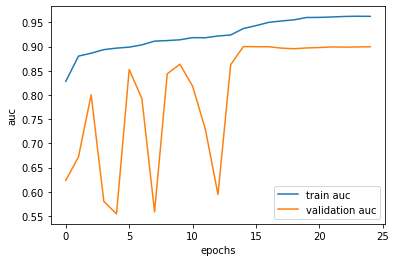

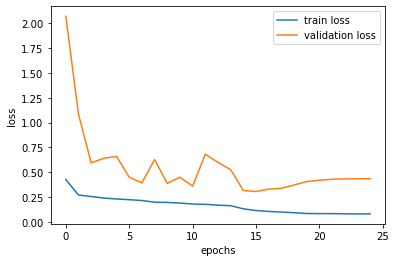

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train auc','validation auc'])
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()



In [115]:
model.load_weights('../../output/checkpoints/mobilenetv2/512_128weights.16-0.31.hdf5')
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

In [116]:
model.evaluate(test_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-11 20:37:51.514510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


153/153 [==============================] - 10s 62ms/step - loss: 0.2524 - accuracy: 0.8995


[0.25244197249412537, 0.8995078206062317]

In [117]:
y = []
x = []

for image,label in  test_dataset.take(40):
    for l in label:
        y.append(l)
    for im in image:
        x.append(im)

In [118]:
import numpy as np
y = np.array(y)
x = np.array(x)
print(y.shape,x.shape)

(640, 2) (640, 256, 256, 3)


In [119]:
predictions = model.predict(x)
predictions = predictions.reshape(640,2)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-11 20:38:04.998793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [120]:
predictions = [int(xx[0]<xx[1]) for xx in predictions]
y = [int(yy[0]<yy[1]) for yy in y]

In [121]:
import pandas as pd
df = pd.DataFrame({'ytrue':y,'pred':predictions})
df['ytrue'].value_counts()

0    331
1    309
Name: ytrue, dtype: int64

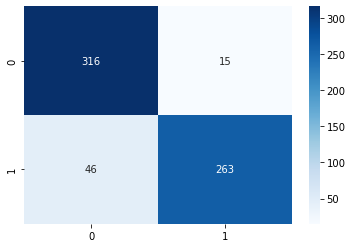

In [122]:
import seaborn as sns
cm = tf.math.confusion_matrix(y,predictions)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

In [160]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_cam_heatmap(img_array,model, layer_name,cam_path="cam.jpg"):
    
        #Get the 128 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]

        get_output = K.function(
            [model.input], 
            [model.get_layer(layer_name).output, model.output])
        
        [conv_outputs, predictions] = get_output([img_array])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        
        for i,w in enumerate(class_weights[:, 0]):
            cam += w * conv_outputs[:, :, i]
            
        cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)

        return cam.numpy()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    grads=grads[0,:,:,:]

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.math.multiply(last_conv_layer_output,grads)
    heatmap = tf.reduce_sum(heatmap,axis=-1)
#     heatmap = tf.keras.layers.Sigmoid()(heatmap)

    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [161]:
def save_and_display_gradcam(img, heatmap, pos, cam_path="cam.jpg", alpha=0.4,title='input'):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    plt.subplot(5,2,pos)
    plt.title(title)
    plt.imshow(superimposed_img)



In [162]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [163]:
x = []
for image,label in  test_dataset.take(40):
    for im in image:
        x.append(im)
x = np.array(x)

In [164]:
filename = glob.glob(r'../../dataset/CXRMSP/train/ABNORMAL/*.*')

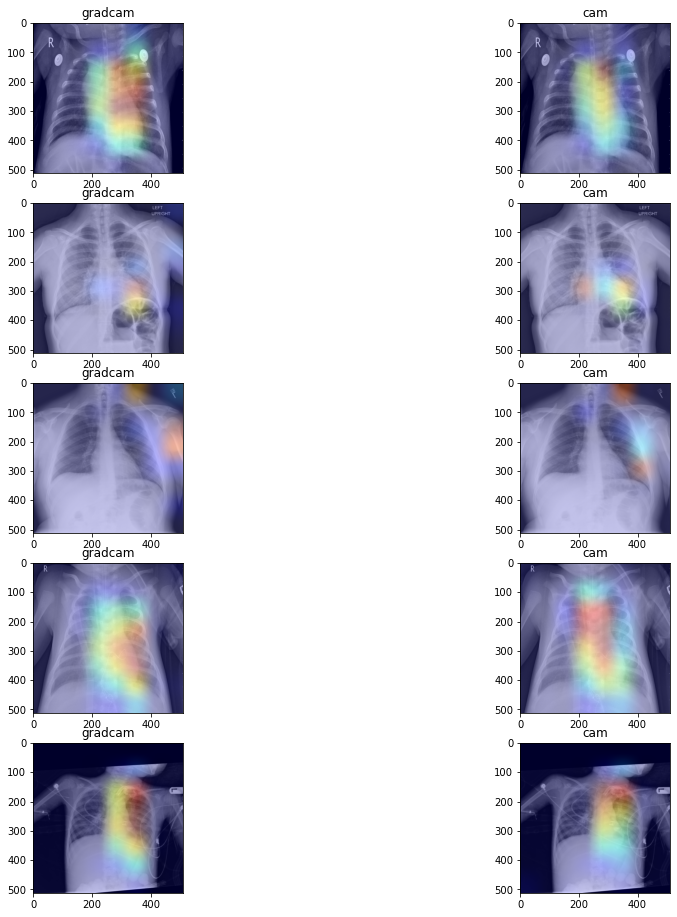

In [165]:
plt.figure(figsize=(16, 16))

for count in range(1,6):#(len(filename)):
    im = cv2.imread(filename[count])
    im = cv2.resize(im, (512,512), interpolation = cv2.INTER_AREA)
    img = tf.keras.preprocessing.image.load_img(
        filename[count],
        color_mode='rgb', 
        target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img)

    img = np.reshape(img,(1,256,256,3))
    model.predict(img)
    
    heatmap_cam = make_cam_heatmap(img, model, 'final_conv')
    heatmap_gradcam = make_gradcam_heatmap(img, model, 'final_conv')
    save_and_display_gradcam(im, heatmap_gradcam,2*count-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_cam,2*count,title='cam')
    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-11 20:55:35.111856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


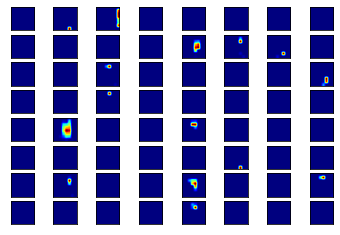

In [167]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'final_conv'

model = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = load_img(filename[1], target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = preprocess_input(image)

# Apply the model to the image
feature_maps = model.predict(image)

square = 8
index = 1
for _ in range(square):
    for _ in range(square):
        
        ax = plt.subplot(square, square, index)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(feature_maps[0, :, :, index-1], cmap='jet')
        index += 1
        
plt.show()